## Modeling


#### Imports

In [1]:
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


#### Data Read In and Preprocessing

In [2]:
sequences = pd.read_csv("../data/word_sequences.csv")

sequences.head(10)

,previous_word,one_word,one_word_next,two_word,two_word_next,three_word,three_word_next
0,\n,from,fairest,"('from', 'fairest')",creatures,"('from', 'fairest', 'creatures')",we
1,from,fairest,creatures,"('fairest', 'creatures')",we,"('fairest', 'creatures', 'we')",desire
2,fairest,creatures,we,"('creatures', 'we')",desire,"('creatures', 'we', 'desire')",increase
3,creatures,we,desire,"('we', 'desire')",increase,"('we', 'desire', 'increase')",","
4,we,desire,increase,"('desire', 'increase')",",","('desire', 'increase', ',')",\n
5,desire,increase,",","('increase', ',')",\n,\n,\n
6,increase,",",\n,\n,\n,\n,\n
7,\n,that,thereby,"('that', 'thereby')",beauty's,"('that', 'thereby', ""beauty's"")",rose
8,that,thereby,beauty's,"('thereby', ""beauty's"")",rose,"('thereby', ""beauty's"", 'rose')",might
9,thereby,beauty's,rose,"(""beauty's"", 'rose')",might,"(""beauty's"", 'rose', 'might')",never


In [3]:
dropping = sequences[sequences["three_word"] == "\n"].index

In [4]:
sequences.drop(index = dropping, inplace = True)

In [5]:
# formatting joys never end 
# each list was saved as one string, so each thing has to be broken up into individual segments again 
# each segment has to be scrubbed of extraneous puncuation 

three_word = []

for line in sequences["three_word"]: 
    line_list = line.split(" ")
    line_formatted = []
    for word in line_list: 
        w = word.replace(")", "").replace("(", "")
        if len(w) == 3 and w.count(',') == 1: 
            line_formatted.append(w.replace("'", ""))
        elif w.count("'") == 1: 
            line_formatted.append(w.replace(",", "").replace('"', ""))
        else: 
            line_formatted.append(w.replace("'", "").replace(",", ""))
    three_word.append(line_formatted)

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(three_word)

tokenizer.texts_to_matrix(three_word)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
len(tokenizer.word_index)

3217

In [9]:
len(tokenizer.word_counts)

3217

In [10]:
mega_vec = []

for seq in three_word: 
    seq_vec = []
    for word in seq:
        
        vector = [0] * (len(tokenizer.word_index) + 1)
        vector[tokenizer.word_index[word]] = 1
        
        seq_vec.append(vector)
        
    mega_vec.append(seq_vec)

In [11]:
three_word_vecs_FIXED = np.array(mega_vec)

In [12]:
# use keras's Tokenizer to one-hot encode three word sequences and next word list

tokenizer = Tokenizer()
tokenizer.fit_on_texts(three_word)

three_word_vecs = []
for seq in three_word: 
    three_word_vecs.append(tokenizer.texts_to_matrix(seq))

In [13]:
next_word_vecs = tokenizer.texts_to_matrix(sequences["three_word_next"])

In [14]:
len(next_word_vecs)

16003

In [15]:
three_word_vecs_FIXED.shape

(16003, 3, 3218)

In [16]:
a = 1

print(next_word_vecs[a].sum())
print(next_word_vecs[a].argmax())
print(tokenizer.index_word[next_word_vecs[a].argmax()])

1.0
259
desire


#### Modeling

In [17]:
# train/test split

train_vecs = three_word_vecs_FIXED[:13000]
train_next_word = next_word_vecs[:13000]

validation_vecs = three_word_vecs_FIXED[13000:]
validation_next_word = next_word_vecs[13000:]

In [18]:
train_vecs[0].shape

(3, 3218)

In [19]:
# build model 

model = Sequential()

model.add(LSTM(512, input_shape = (3, 3218), return_sequences = True))
model.add(LSTM(256))
model.add(Dense(128, activation = "relu"))
model.add(Dense(3218, activation = "softmax"))

model.compile(loss = "categorical_crossentropy", 
              optimizer = "adam")

In [20]:
history = model.fit(x = train_vecs, y = train_next_word, 
                    verbose = 2, 
                    epochs = 30, 
                    batch_size = 512, 
                    validation_data = (validation_vecs, validation_next_word))

Train on 13000 samples, validate on 3003 samples
Epoch 1/30
 - 14s - loss: 5.5574 - val_loss: 4.9172
Epoch 2/30
 - 12s - loss: 4.7862 - val_loss: 4.9296
Epoch 3/30
 - 12s - loss: 4.6840 - val_loss: 5.2860
Epoch 4/30
 - 12s - loss: 5.0255 - val_loss: 8.3041
Epoch 5/30
 - 12s - loss: 5.9286 - val_loss: 10.4808
Epoch 6/30
 - 12s - loss: 6.4772 - val_loss: 11.0510
Epoch 7/30
 - 12s - loss: 7.1039 - val_loss: 10.5460
Epoch 8/30
 - 12s - loss: 8.1187 - val_loss: 10.1723
Epoch 9/30
 - 15s - loss: 9.3626 - val_loss: 10.4535
Epoch 10/30
 - 13s - loss: 11.7416 - val_loss: 11.0559
Epoch 11/30
 - 12s - loss: 14.4350 - val_loss: 14.0410
Epoch 12/30
 - 12s - loss: 19.0639 - val_loss: 17.9733
Epoch 13/30
 - 14s - loss: 21.5370 - val_loss: 18.8329
Epoch 14/30
 - 13s - loss: 25.8242 - val_loss: 24.2732
Epoch 15/30
 - 13s - loss: 29.7579 - val_loss: 28.2061
Epoch 16/30
 - 13s - loss: 31.5583 - val_loss: 27.9762
Epoch 17/30
 - 17s - loss: 34.1339 - val_loss: 31.6973
Epoch 18/30
 - 19s - loss: 37.9200 - v

In [502]:
pred = model.predict(validation_vecs[96].reshape(1, 3, 3218))

In [503]:
for i in pred[0].argsort()[-20:][::-1]: 
    print(tokenizer.index_word[i])
    print(pred[0][i])
    print()

wardrobe
0.26633182

with
0.25500572

takes
0.14803708

see
0.060847066

thine
0.059176918

as
0.039178062

still
0.030482126

live
0.021617701

the
0.014018053

say
0.013250172

replete
0.011316883

woe
0.010734247

sweet
0.009608619

brow
0.009565318

added
0.009532099

at
0.008029771

could
0.0043166927

lend
0.0042862385

false
0.0037006107

thee
0.0021617115



In [494]:
tokenizer.index_word[83]

'takes'

In [438]:
preds = model.predict(validation_vecs)

In [442]:
preds.shape

(3003, 3218)

In [470]:
tokenizer.index_word[validation_vecs[123].argmax()]

'tender'

## FUCK


In [504]:
def next_word(wurd_list): 
    feed_vec = [] 
    for wurd in wurd_list: 
        
        index = tokenizer.word_index[wurd]
    
        # create array of all zeroes, insert 1 at index of the word 
    
        zeroes = [0] * (len(tokenizer.index_word) + 1)
        zeroes[index] = 1
        
        feed_vec.append(zeroes)
        
    feed_arr = np.array(feed_vec)
    
    # feed that array into the model with reshaping 
    prediction = model.predict(feed_arr.reshape(1, 3, 3218))
    
    for i in prediction[0].argsort()[-20:][::-1]: 
        print(tokenizer.index_word[i])
        print(pred[0][i])
        print()

#     # take prediction and decipher it 
#     next = tokenizer.index_word[prediction.argmax()]
    
#     return f"{wurd_list[0]} {wurd_list[1]} {wurd_list[2]} {next}"

In [534]:
next_word(["thine", "creatures", "wardrobe"])

better
0.0

are
6.725015e-17

with
0.25500572

of
2.728745e-31

joy
1.5509508e-12

them
0.0

in
1.1132816e-08

an
8.037333e-20

to
8.4594585e-23

night
2.1101032e-05

not
1.6544083e-12

spring
0.0

where
7.958371e-06

mind
0.00035446548

show
9.999511e-09

that
5.229358e-11

away
2.1234494e-29

given
0.0

birth
0.0

one
5.5795483e-11



#### Trying: Predictions based on one previous word 

In [301]:
one_word = sequences["one_word"]
one_next = sequences["one_word_next"]

tokenizer_one = Tokenizer()
tokenizer_one.fit_on_texts(one_word)

one_word_vecs = tokenizer_one.texts_to_matrix(one_word)
one_next_vecs = tokenizer_one.texts_to_matrix(one_next)

In [229]:
one_word_vecs.shape

(20315, 3210)

In [346]:
(one_word_vecs[0] == one_word_vecs[0]).sum()

3210

In [348]:
(one_next_vecs[230] == one_next_vecs[891]).sum()

3209

In [360]:
tokenizer_one.word_counts["the"]

444

In [230]:
train_one_vecs = one_word_vecs[:16000]
train_next_vecs = one_next_vecs[:16000]

validation_one_vecs = one_word_vecs[16000:]
validation_next_vecs = one_next_vecs[16000:]

In [276]:
# build model 

model = Sequential()

model.add(LSTM(256, input_shape = (1, 3210)))
model.add(Dense(128, activation = "relu"))
model.add(Dense(3210, activation = "softmax"))

model.compile(loss = "categorical_crossentropy", 
              optimizer = "adam")

In [282]:
callback = [EarlyStopping(patience = 3, monitor = "val_loss", verbose = 1)]

In [366]:
tokenizer_one.index_word[train_one_vecs[1].argmax()]

'fairest'

In [367]:
tokenizer_one.index_word[train_next_vecs[1].argmax()]

'creatures'

In [283]:
model.fit(x = train_one_vecs.reshape(16000, 1, 3210), y = train_next_vecs, 
          verbose = 2, 
          epochs = 30, 
          batch_size = 256, 
          validation_data = (validation_one_vecs.reshape(4315, 1, 3210), validation_next_vecs), 
          callbacks = callback)

Train on 16000 samples, validate on 4315 samples
Epoch 1/30
 - 5s - loss: 5.8083 - val_loss: 5.1603
Epoch 2/30
 - 5s - loss: 5.0001 - val_loss: 5.1831
Epoch 3/30
 - 5s - loss: 4.9340 - val_loss: 5.4405
Epoch 4/30
 - 5s - loss: 5.0678 - val_loss: 7.1492
Epoch 00004: early stopping


In [286]:
result = model.predict(validation_one_vecs.reshape(4315, 1, 3210))

In [306]:
result[0].max()

0.01621103

In [340]:
result[100].argsort()[-5:][::-1]

array([ 3,  8, 19, 13,  2])

In [334]:
result[97].argmax()

3

In [321]:
validation_one_vecs[4].argmax()

18

In [322]:
tokenizer_one.index_word[18]

'me'

#### Graphs

In [21]:
import matplotlib.pyplot as plt

In [22]:
loss = history.historyry["loss"]
val_loss = history.history["val_loss"]

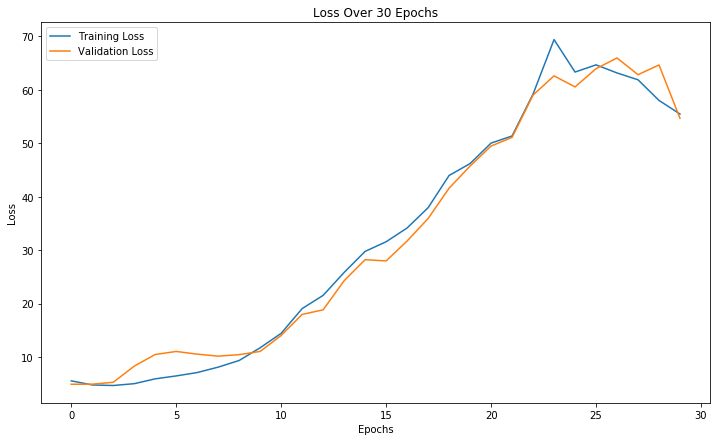

In [25]:
plt.figure(figsize = (12, 7))
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.title("Loss Over 30 Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("../plots/bad_loss.png"); 